With deberta RM

## Imports

In [ ]:
# after running PPO TRL - adapted.ipynb

In [ ]:
!pip install trl
!pip install datasets
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.2/245.2 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 14.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tqdm import tqdm
import os

import torch
from torch.utils.data import Dataset
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead, create_reference_model
from transformers import AutoTokenizer, pipeline
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoModelForSequenceClassification

In [ ]:
import numpy as np
import json

## Dataset


In [ ]:
path = "/content/drive/MyDrive/NLP/gpt4_generations.csv"
tokenizer_path='/content/drive/MyDrive/NLP/SFT_GPT-2M_Dolly15k'

In [ ]:
#Load dataset into torch.utils.data
class SubredditQuestionDataset(Dataset):
    def __init__(self, path, block_size=512, num_records=512, tokenizer_path='/content/drive/MyDrive/SFT_GPT-2M_Dolly15k'):
        super().__init__()
        dataset = load_dataset('csv',data_files=path)
        tokenizer = AutoTokenizer.from_pretrained('gpt2-medium', padding=True, max_length=block_size, padding_side='left')
        tokenizer.pad_token = tokenizer.eos_token

        print('Loading the dataset- method 1')

        def tokenize_this(sample):
            # sample['Question'] = 'Question:'+sample['Question']+'\n Answer:'
            sample['input_ids'] = tokenizer.encode(sample['Questions'])
            return sample

        dataset = dataset.remove_columns(['Domain'])
        dataset = dataset['train'].select(range(num_records))
        dataset = dataset.map(tokenize_this, batched=False)
        dataset = dataset.rename_columns({'Questions':'query'})
        dataset.set_format(type="torch")

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]


In [ ]:
subreddit_question_dataset = SubredditQuestionDataset(path, block_size=512, num_records=2000)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading the dataset- method 1


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

## RLHF Setup and Training

#### Load tokenizer, model, ref model, config

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, max_length=512)
# tokenizer = AutoTokenizer.from_pretrained('gpt2-medium', max_length=512, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
config = PPOConfig(
    model_name='gpt2-medium',
    batch_size=16,
    mini_batch_size=8,
    steps=140,
)

In [ ]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(tokenizer_path)
# model = AutoModelForCausalLMWithValueHead.from_pretrained('gpt2-medium')
ref_model = create_reference_model(model)


# ref_model = AutoModelForCausalLMWithValueHead.from_pretrained('gpt2-medium')

In [ ]:
import gc
gc.collect()

78

#### PPO Trainer object

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ['TORCH_USE_CUDA_DSA']='1'

In [ ]:
ppo_trainer = PPOTrainer(
    config,
    model,
    ref_model,
    tokenizer,
    dataset=subreddit_question_dataset,
    data_collator=collator
)

In [ ]:
device = ppo_trainer.accelerator.device
device

device(type='cuda')

In [ ]:
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else 'cpu'
device

0

#### Generation arguments, regular and for negative KL

In [ ]:
generation_kwargs = {
    'min_length': -1,
    'top_k': 32,
    'top_p': 0.9,
    'do_sample': True,
    'max_new_tokens': 512,
    # 'temperature':0.1,
    # 'pad_token_id': tokenizer.eos_token_id
}

In [ ]:
generation_kwargs_for_negKL = {
    "min_length": -1, # don't ignore the EOS token (see above)
    "top_k": 0.0, # no top-k sampling
    "top_p": 1.0, # no nucleus sampling
    "do_sample": True, # yes, we want to sample
    "pad_token_id": tokenizer.eos_token_id, # most decoder models don't have a padding token - use EOS token instead
    "eos_token_id": -1,
    "max_new_tokens": 64, # specify how many tokens you want to generate at most
    "temperature": 0.9,
    # "padding":True
}

#### Reward Model

In [ ]:
# reward_tokenizer = T5Tokenizer.from_pretrained('stanfordnlp/SteamSHP-flan-t5-large')
# reward_model = T5ForConditionalGeneration.from_pretrained('stanfordnlp/SteamSHP-flan-t5-large').to(device)
reward_name = "OpenAssistant/reward-model-deberta-v3-large-v2"
reward_model, reward_tokenizer = AutoModelForSequenceClassification.from_pretrained(reward_name).to('cuda'), AutoTokenizer.from_pretrained(reward_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/993 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/455 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [ ]:
# def get_reward(batch_question, batch_response):
#     outputs = []
#     for i in range(len(batch_question)):
#         p = batch_question[i]
#         resp = batch_response[i]
#         text = "POST: "+ p.replace('\n', ' ') +"\n \n RESPONSE A: " + resp.replace('\n', ' ') + "\n\n RESPONSE B: .\n\n Which response is better? RESPONSE"
#         x = reward_tokenizer([text], return_tensors='pt').input_ids.to(device)
#         output = reward_model.generate(x, return_dict_in_generate=True, output_scores=True, max_new_tokens=1)

#         outputs.append((torch.exp(output.scores[0][:, 71]) / torch.exp(output.scores[0][:,:]).sum(axis=1).item())-0.8) # index 71 corresponds to the token for 'A'
#     return outputs


In [ ]:
def get_reward(batch_question, batch_response):
    outputs = []
    for i in range(len(batch_question)):
        p = batch_question[i]
        resp = batch_response[i]
        inputs = reward_tokenizer(p, resp, return_tensors='pt').to('cuda')
        score = reward_model(**inputs).logits[0].cpu().detach()
        outputs.append(score)

    return outputs

In [ ]:
# get_reward(["Imagine you're a historian writing a biography about the impact of the internet on human communication and social interaction in the 21st century. Briefly summarize the key developments and changes brought about by the internet, highlighting both positive and negative consequences."], ["The emergence of the internet in the late 20th century revolutionized human communication and social interaction.  Previously isolated communities gained access to a global network, fostering cultural exchange and collaboration on a previously unimaginable scale.  The rise of social media platforms facilitated the creation of online communities based on shared interests, providing a sense of belonging and connection for many.  However, the internet also brought challenges.  The spread of misinformation and the rise of echo chambers fueled social and political polarization.  Cyberbullying and online harassment became prevalent issues, particularly for young people.  Overall, the internet's impact on human communication remains complex and multifaceted, offering both opportunities and challenges that continue to shape societies worldwide."])

#### Training!

In [ ]:
# for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
#     query_tensors = batch['input_ids']

#     response_tensors = []
#     for query in query_tensors:
#         response = ppo_trainer.generate(query.squeeze(), **generation_kwargs_for_negKL)
#         # print(tokenizer.decode(response.squeeze()))
#         # print('***')
#         # print(query.shape)
#         # break

#         response_tensors.append(response.squeeze()[-64:])
#     batch['response'] = [tokenizer.decode(r.squeeze()) for r in response_tensors]
#     print('Q',batch['query'])
#     print('****')
#     print('R',batch['response'])

#     rewards = get_reward(batch['query'], batch['response'])

#     break


0it [00:00, ?it/s]

Q ['What are the emerging trends in abstract writing that I should be aware of?', "I'm a 38M and I've been experiencing pain in my calf muscles when I walk or run. Could it be a sign of peripheral artery disease?", 'What are the potential benefits and challenges of using participatory approaches to governance in promoting sustainable development?', 'Can anyone recommend software or techniques for modeling and simulating system reliability?', 'CMV: The concept of "cultural appropriation" is a valid concern, but I struggle with the idea that it\'s always harmful.', 'How do cultural and demographic factors shape political attitudes and participation?', 'If I have a hunch or intuition about something, is that a valid form of knowledge?', "**Plasma Physics:** What's the difference between plasma and a regular gas?", 'ELI5: How does a mirror work?', 'What are some cool insights from the study of digital artifacts, like social media posts or online game interactions?', 'What is the role of te

0it [00:33, ?it/s]


In [ ]:
rewards

[-3.2141239643096924,
 -3.446850061416626,
 -2.2400753498077393,
 -3.2795679569244385,
 -4.224772930145264,
 -3.3028554916381836,
 -3.118770122528076,
 -3.184255838394165,
 -2.541121006011963,
 -3.1114602088928223,
 -2.2510173320770264,
 -3.7068769931793213,
 -1.789454460144043,
 -4.719831466674805,
 -2.0103602409362793,
 -3.6912214756011963]

In [ ]:
stat_list = []
for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = batch['input_ids']

    response_tensors = []
    for query in query_tensors:
        response = ppo_trainer.generate(query.squeeze(), **generation_kwargs_for_negKL)

        response_tensors.append(response.squeeze()[-64:])
    batch['response'] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    rewards = get_reward(batch['query'], batch['response'])

    stats = ppo_trainer.step(
        query_tensors,
        response_tensors,
        rewards
    )
    stat_list.append({'stats': stats, 'batch':batch, 'rewards': rewards})

    ppo_trainer.log_stats(stats, batch, rewards)


81it [50:04, 37.11s/it]/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (13.29) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
125it [1:17:19, 37.12s/it]


In [ ]:
ppo_trainer.save_pretrained("/content/drive/MyDrive/NLP/PPO_Method2_Iteration1-1-with-")

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1407: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


In [ ]:
temp = []
for s in stat_list:
    temp.append(s['stats'])

for t in temp:
    for key in t.keys():
        if isinstance(t[key], np.ndarray):
            t[key] = t[key].tolist()


In [ ]:
with open("/content/drive/MyDrive/NLP/PPO_Method2_Iteration1-1-STATS.json", "w") as outfile:
    json.dump({'stats':temp}, outfile)

Iteration 2

In [ ]:
stat_list = []
for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = batch['input_ids']

    response_tensors = []
    for query in query_tensors:
        response = ppo_trainer.generate(query.squeeze(), **generation_kwargs_for_negKL)

        response_tensors.append(response.squeeze()[-64:])
    batch['response'] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    rewards = get_reward(batch['query'], batch['response'])

    stats = ppo_trainer.step(
        query_tensors,
        response_tensors,
        rewards
    )
    stat_list.append({'stats': stats, 'batch':batch, 'rewards': rewards})

    ppo_trainer.log_stats(stats, batch, rewards)


27it [16:50, 37.44s/it]/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (285.57) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (409.54) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
65it [40:28, 37.19s/it]/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (201.15) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (1683.55) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1222: UserWarning: The average ratio of batch (329.00) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
125it [1:17:38, 37.27s/it]


In [ ]:
ppo_trainer.save_pretrained("/content/drive/MyDrive/NLP/PPO_Method2_Iteration1-2")

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1407: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


In [ ]:
temp = []
for s in stat_list:
    temp.append(s['stats'])

for t in temp:
    for key in t.keys():
        if isinstance(t[key], np.ndarray):
            t[key] = t[key].tolist()


In [ ]:
with open("/content/drive/MyDrive/NLP/PPO_Method2_Iteration1-2-STATS.json", "w") as outfile:
    json.dump({'stats':temp}, outfile)

In [ ]:
generator_for_ppo = pipeline('text-generation', model='/content/drive/MyDrive/NLP/PPO_Iteration1_Dberta_2000_may15_1AM')

Some weights of the model checkpoint at /content/drive/MyDrive/NLP/PPO_Iteration1_Dberta_2000_may15_1AM were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
generator_for_ppo('ELI5: Should you take a shower during a thunderstorm?', **generation_kwargs_for_negKL)

[{'generated_text': 'ELI5: Should you take a shower during a thunderstorm?It is possible to take a shower during a thunderstorm. The problem is that the energy often is too strong for the material to disperse; it merely falls to the ground like rain. If you are considering taking a shower, make sure you have a strong enough shower head so that it does not interfere with your surroundings'}]

In [ ]:
generator_for_bm = pipeline('text-generation', model='/content/drive/MyDrive/NLP/SFT_GPT-2M_Dolly15k', **generation_kwargs_for_negKL)
generator_for_bm('ELI5: Should you take a shower during a thunderstorm?')

[{'generated_text': "ELI5: Should you take a shower during a thunderstorm?A: Few people have confirmed that showering on a rainy day is a good idea, however, the science doesn't seem to support it. There are several studies that have shown that storms pass through showers more often than it does. However, no one study is definitively with the idea that showers are more frequent in"}]

In [ ]:
gen_for_inference = {'min_length': -1,
 'top_k': 0.0,
 'top_p': 1.0,
 'do_sample': True,
 'pad_token_id': 50256,
 'eos_token_id': -1,
 'max_new_tokens': 128,
 'temperature': 0.9}

In [ ]:
for i in range(10):
    q = subreddit_question_dataset[i]['query']
    print('PPO:',generator_for_ppo(q, **gen_for_inference))
    print('\n')
    print('BM:',generator_for_bm(q, **gen_for_inference))
    print('*************')


PPO: [{'generated_text': 'What are the signs of a failing transmission and how can I prevent it?Signs of a failing transmission are the following:\n- No current flow within the circuit\n- Incomplete or unplanned delivery of the property\n- Bad signal in the middle of the circuit\n- No power consumption within the circuit\n- No signal from nearby power lines\n- Poor signal reception in the middle of the circuit\n- The signal from the nearest power lines is poor but the transmission quality is good\n- Customer service is poor\n- The storage capacity of the property has been damaged causing the failure\n- The property has been damaged by floods\n- The property has been damaged by earthquakes\n- The property has been'}]


BM: [{'generated_text': 'What are the signs of a failing transmission and how can I prevent it?Having a transmission failure is one of the worst things to happen to any vehicle.  You should be concerned if your transmission is failing and it should come as no surprise to 

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
it = stat_list[0]
it['stats']['ppo/loss/policy']

{'stats': {'objective/kl': 0.0,
  'objective/kl_dist': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        dtype=float32),
  'objective/logprobs': array([[-5.0586977e+00, -3.9400687e+00, -4.9377604e+00, ...,
          -6.3157783e+00, -6.3320289e+00, -6.3535028e+00],
         [-3.1487455e+00, -1.3335496e+00, -6.3358803e+00, ...,
          -4.9796133e+00, -4.9994888e+00, -5.0209880e+00],
         [-1.0997008e+00, -3.6269202e+00, -1.2213175e+00, ...,
          -1.0630738e+00, -1.0711116e+00, -1.0736156e+00],
         ...,
         [-1.8173887e+01, -4.0663495e+00, -9.3378775e-02, ...,
          -1.1229172e+01, -1.9530461e+00, -1.9592776e+00],
         [-1.8206497e+01, -8.6205378e+00, -4.4827557e+00, ...,
          -1.9634830e+00, -7.3438221e-01, -1.1817385e-03],
         [-1.6905795e+00, -9.7979250e+00, -7.7350430e+00, ...,
          -7.8824010e+00, -7.8932691e+00, -7.8931484e+00]], dtype=float32),
  'objective/ref_logprobs': array([[-5.0586977e+00, -3.9400687e+

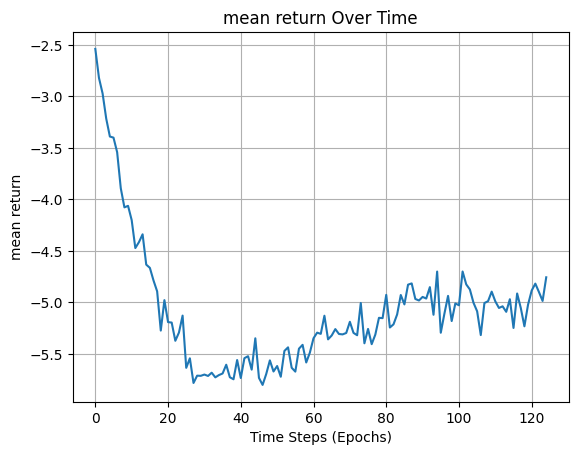

In [ ]:
temp = []
for it in stat_list:
    temp.append(it['stats']['ppo/returns/mean'])
plt.plot(range(len(temp)), temp, label='returns ')
plt.xlabel('Time Steps (Epochs)')
plt.ylabel('mean return')
plt.title('mean return Over Time')
plt.grid(True)
plt.show()

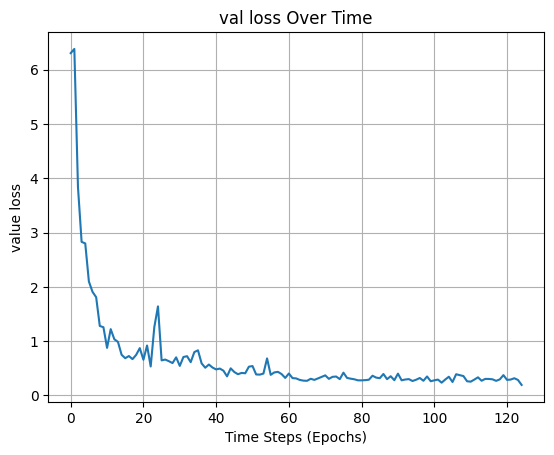

In [ ]:
temp = []
for it in stat_list:
    temp.append(it['stats']['ppo/loss/value'])
plt.plot(range(len(temp)), temp, label='value loss ')
plt.xlabel('Time Steps (Epochs)')
plt.ylabel('value loss')
plt.title('val loss Over Time')
plt.grid(True)
plt.show()

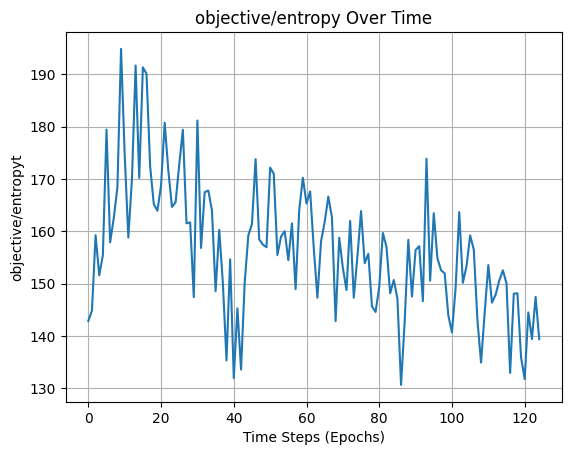

In [ ]:
temp = []
for it in stat_list:
    temp.append(it['stats']['objective/entropy'])
plt.plot(range(len(temp)), temp, label='objective/entropy')
plt.xlabel('Time Steps (Epochs)')
plt.ylabel('objective/entropyt')
plt.title('objective/entropy Over Time')
plt.grid(True)
plt.show()

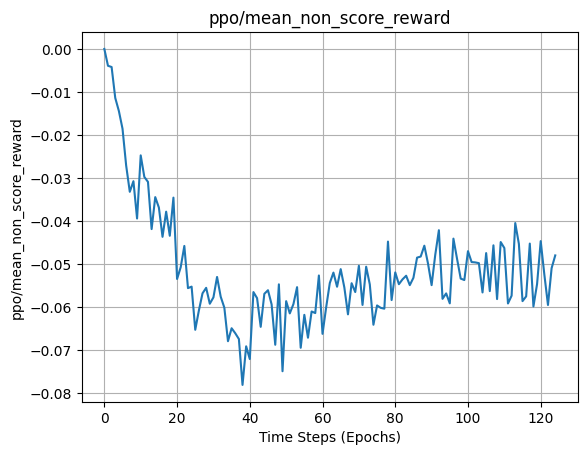

In [ ]:
temp = []
for it in stat_list:
    temp.append(it['stats']['ppo/mean_non_score_reward'])
plt.plot(range(len(temp)), temp, label='ppo/mean_non_score_reward')
plt.xlabel('Time Steps (Epochs)')
plt.ylabel('ppo/mean_non_score_reward')
plt.title('ppo/mean_non_score_reward')
plt.grid(True)
plt.show()

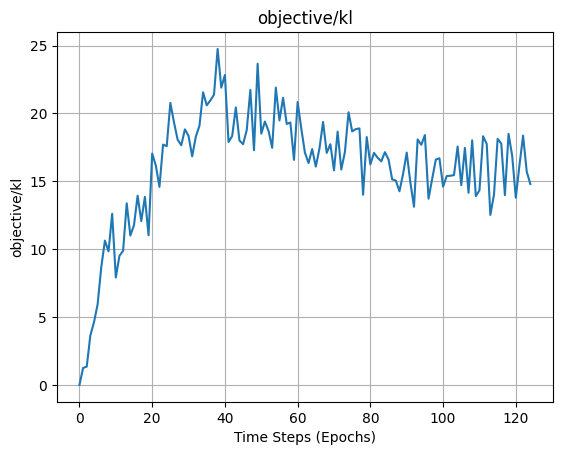

In [ ]:
temp = []
for it in stat_list:
    temp.append(it['stats']['objective/kl'])
plt.plot(range(len(temp)), temp, label='objective/kl')
plt.xlabel('Time Steps (Epochs)')
plt.ylabel('objective/kl')
plt.title('objective/kl')
plt.grid(True)
plt.show()

In [ ]:
temp = []
for s in stat_list:
    temp.append(s['stats'])

In [ ]:
temp

[{'objective/kl': 0.0,
  'objective/kl_dist': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        dtype=float32),
  'objective/logprobs': array([[-5.0586977e+00, -3.9400687e+00, -4.9377604e+00, ...,
          -6.3157783e+00, -6.3320289e+00, -6.3535028e+00],
         [-3.1487455e+00, -1.3335496e+00, -6.3358803e+00, ...,
          -4.9796133e+00, -4.9994888e+00, -5.0209880e+00],
         [-1.0997008e+00, -3.6269202e+00, -1.2213175e+00, ...,
          -1.0630738e+00, -1.0711116e+00, -1.0736156e+00],
         ...,
         [-1.8173887e+01, -4.0663495e+00, -9.3378775e-02, ...,
          -1.1229172e+01, -1.9530461e+00, -1.9592776e+00],
         [-1.8206497e+01, -8.6205378e+00, -4.4827557e+00, ...,
          -1.9634830e+00, -7.3438221e-01, -1.1817385e-03],
         [-1.6905795e+00, -9.7979250e+00, -7.7350430e+00, ...,
          -7.8824010e+00, -7.8932691e+00, -7.8931484e+00]], dtype=float32),
  'objective/ref_logprobs': array([[-5.0586977e+00, -3.9400687e+00, -4.93

In [ ]:
import numpy as np

In [ ]:
for t in temp:
    for key in t.keys():
        if isinstance(t[key], np.ndarray):
            t[key] = t[key].tolist()

In [ ]:
import json

In [ ]:
with open("/content/drive/MyDrive/NLP/PPO_Iteration1_Dberta_2000_may15_1AM-STATS.json", "w") as outfile:
    json.dump({'stats':temp}, outfile)

In [ ]:
assim = []
for r in rewards_across:
  assim.append(torch.tensor(r).mean())
assim

[tensor(0.0119),
 tensor(0.0352),
 tensor(0.0239),
 tensor(0.0258),
 tensor(0.0199),
 tensor(0.0293),
 tensor(0.0690),
 tensor(0.0021),
 tensor(0.0326),
 tensor(0.0115),
 tensor(0.0284),
 tensor(0.0356),
 tensor(0.0707),
 tensor(0.0020),
 tensor(0.0195),
 tensor(0.0116),
 tensor(0.0281),
 tensor(0.0492),
 tensor(0.0444),
 tensor(0.0159),
 tensor(0.0096),
 tensor(0.0456),
 tensor(0.0230),
 tensor(0.0412),
 tensor(0.0092),
 tensor(0.0312),
 tensor(0.0567),
 tensor(0.0211),
 tensor(0.0606),
 tensor(0.0681),
 tensor(0.0529),
 tensor(0.0354),
 tensor(0.0169),
 tensor(0.0402),
 tensor(-0.0201),
 tensor(-0.0054),
 tensor(0.0180),
 tensor(0.0247),
 tensor(-0.0024),
 tensor(0.0637),
 tensor(0.0119),
 tensor(0.0427),
 tensor(0.0231),
 tensor(0.0386),
 tensor(0.0531),
 tensor(-0.0161),
 tensor(0.0542),
 tensor(-0.0220),
 tensor(0.0578),
 tensor(0.0227),
 tensor(0.0190),
 tensor(0.0526),
 tensor(0.0437),
 tensor(0.0403),
 tensor(0.0618),
 tensor(0.0477),
 tensor(0.0428),
 tensor(0.0393),
 tensor(0

In [ ]:
len(assim)

62

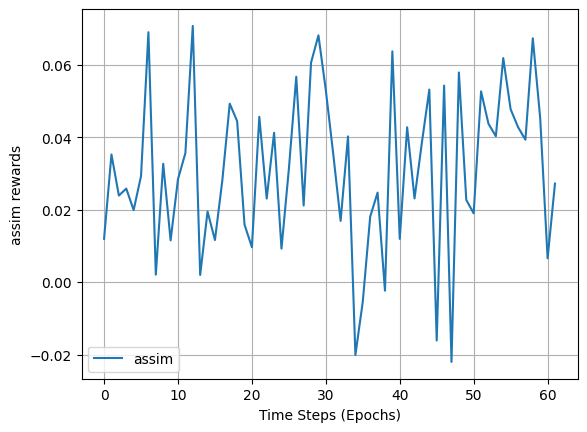

In [ ]:
plt.plot(range(len(assim)), assim, label='assim')
plt.xlabel('Time Steps (Epochs)')
plt.ylabel('assim rewards')
# plt.title('')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
ppo_trainer.save_pretrained("/content/drive/MyDrive/NLP/ppo_trial_2_base_model")

KeyboardInterrupt: 

In [ ]:
# below with sft

In [ ]:
ppo_trainer.save_pretrained("ppo_trial_1_local")

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1407: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


In [ ]:
ppo_trainer.save_pretrained("/content/drive/MyDrive/NLP/ppo_trial_1")

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_trainer.py:1407: UserWarning: Cannot retrieve user information assuming you are running in offline mode.
  warnings.warn("Cannot retrieve user information assuming you are running in offline mode.")


In [ ]:
stats

{'objective/kl': 2.946293354034424,
 'objective/kl_dist': array([-0.66302127,  2.8498356 ,  3.19665   ,  9.534701  , -0.9466222 ,
        -0.3183734 ,  3.1920571 ,  6.803298  ,  4.6041822 ,  2.8746948 ,
        -0.34017658,  4.3399286 ,  0.4698336 ,  4.3529863 ,  3.8622794 ,
         3.3284392 ], dtype=float32),
 'objective/logprobs': array([[-1.1784125e+01, -1.3780290e+00, -6.6172695e+00, ...,
         -6.0849646e-03, -5.7546892e-03, -5.7753124e-03],
        [-5.1949606e+00, -3.3549047e+00, -3.6020908e+00, ...,
         -1.1491131e-03, -1.1064843e-03, -1.1070797e-03],
        [-9.8709784e+00, -3.7733784e+00, -2.9930689e+00, ...,
         -1.7292209e-02, -1.6177928e-02, -1.6271761e-02],
        ...,
        [-5.5445237e+00, -2.6060364e+00, -1.4919379e+00, ...,
         -6.1200359e-03, -5.8049429e-03, -5.8047059e-03],
        [-1.4074701e+00, -7.9836279e-01, -6.5081701e+00, ...,
         -4.0227603e-02, -3.7933763e-02, -3.8064595e-02],
        [-1.9443618e+00, -4.3943787e+00, -3.4905005

#### Load model from trained

In [ ]:
from transformers import AutoModelForCausalLM, pipeline

In [ ]:
# model_trained_ppo = AutoModelForCausalLM.from_pretrained('/content/drive/MyDrive/NLP/ppo_trial_1')
# this is when using for inference

Some weights of the model checkpoint at /content/drive/MyDrive/NLP/ppo_trial_1 were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# tokenizer_from_trained_ppo = AutoTokenizer.from_pretrained('/content/drive/MyDrive/NLP/ppo_trial_1')

In [ ]:
generator_for_ppo = pipeline('text-generation', model='gpt2-medium')

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
generator_for_ppo = pipeline('text-generation', model='/content/drive/MyDrive/NLP/ppo_trial_1')

Some weights of the model checkpoint at /content/drive/MyDrive/NLP/ppo_trial_1 were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
generator2 = pipeline('text-generation', model='/content/drive/MyDrive/NLP/SFT_GPT-2M_Dolly15k')

In [ ]:
generator2("Should I take a shower during a thunderstorm?")

[{'generated_text': 'Should I take a shower during a thunderstorm?'}]

In [ ]:
generator_for_ppo("This movie was really", max_length=512)[0]["generated_text"]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'This movie was really great. It shows us the future that we know will be here in the future, maybe in this part of the universe, maybe not. You gotta be prepared or the whole world will be destroyed. With the amount of things that people are thinking about, this is one of those things that you\'re going to have to deal with." - James Wan (Screamer Trilogy).\n\nFor the most part, this is where the first film was going, with a few scenes being shot in New Zealand but none of them being anything of the sort. The movie was to be shot entirely between Hawaii and Europe and most of the team made it to one point, and one was killed while on the way, so the film was cut short.\n\nWhile the filmmakers were attempting to save most of the team, they also had another film that they had to make - an adaptation of an unknown book. While the film was essentially called War from another World, it didn\'t go to print, and while people did have the rights to it, the producers felt it wasn\'t very good.

In [ ]:
generator_for_ppo("Should I take a shower during a thunderstorm?")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Should I take a shower during a thunderstorm?\n\nYes! This means that we will need to stop all activities, work, school, shopping and other activities before the storm hits (no outside water sources). It takes hours for the water to'}]

In [ ]:
# if continuing training, model = AutoModelForCausalLMWithValueHead.from_pretrained("my-fine-tuned-model-ppo")

In [ ]:
generator_for_ppo("After receiving an email from a sketchy journal soliciting submissions, a professor sent in a joke paper titled 'What's the Deal With Birds?', which got published. Here's a small excerpt from the paper: > *Abstract:* Many people wonder: what’s the deal with birds? This is a common query. Birds are pretty weird. I mean, they have feathers. WTF? Most other animals don’t have feathers. To investigate this issue, I looked at some birds. I looked at a woodpecker, a parrot, and a penguin. They were all pretty weird! In conclusion, we may never know the deal with birds, but further study is warranted. > *Keywords*: birds, ornithology, behavior, phenotype, WTF, genomics, climate change You can read the PDf version of the original article here: ")

NameError: name 'generator_for_ppo' is not defined

In [ ]:
generator_BM = pipeline('text-generation', '/content/drive/MyDrive/NLP/ppo_trial_2_base_model')

Some weights of the model checkpoint at /content/drive/MyDrive/NLP/ppo_trial_2_base_model were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
generator_SFT = pipeline('text-generation', model='/content/drive/MyDrive/NLP/ppo_trial_1')

Some weights of the model checkpoint at /content/drive/MyDrive/NLP/ppo_trial_1 were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
generator_SFT_PPO = pipeline('text-generation', model='/content/drive/MyDrive/NLP/ppo_trial_1')
generator_BM_PPO = pipeline('text-generation', '/content/drive/MyDrive/NLP/ppo_trial_2_base_model')

cnt = 0
for data in subreddit_question_dataset:
    print(data['query'])
    print('Base+PPO' ,generator_BM_PPO(data['query'])[0]['generated_text'])
    print('SFT+PPO', generator_SFT_PPO(data['query'])[0]['generated_text'])

    print('________')
    cnt +=1
    if cnt == 15:
        break

Some weights of the model checkpoint at /content/drive/MyDrive/NLP/ppo_trial_1 were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at /content/drive/MyDrive/NLP/ppo_trial_2_base_model were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertFo

What are the signs of a failing transmission and how can I prevent it?
Base+PPO What are the signs of a failing transmission and how can I prevent it??"
SFT+PPO What are the signs of a failing transmission and how can I prevent it?

A failing transmission is the transmission that fails to transmit a signal that indicates a problem 


________
**I'm stumped:** How can I optimize the design of a heat exchanger using CFD simulations while considering both thermal performance and cost?
Base+PPO **I'm stumped:** How can I optimize the design of a heat exchanger using CFD simulations while considering both thermal performance and cost?
SFT+PPO **I'm stumped:** How can I optimize the design of a heat exchanger using CFD simulations while considering both thermal performance and cost?
________
What are the key differences between practicum and internship? How do I tailor my expectations accordingly?
Base+PPO What are the key differences between practicum and internship? How do I tailor my expe

In [ ]:
generator_SFT = pipeline('text-generation', model='/content/drive/MyDrive/NLP/SFT_GPT-2M_Dolly15k')

generator_Base = pipeline('text-generation', model='gpt2-medium')

cnt = 0
for data in subreddit_question_dataset:
    print(data['query'])
    print('only base', generator_Base('Question:'+data['query']+'Answer:')[0]['generated_text'])
    print('only sft', generator_SFT('Question:'+data['query']+'Answer:')[0]['generated_text'])

    print('________')
    cnt +=1
    if cnt == 15:
        break

model.safetensors:  81%|########  | 1.23G/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question:What are the signs of a failing transmission and how can I prevent it?
 Answer:
only base Question:Question:What are the signs of a failing transmission and how can I prevent it?
 Answer:Answer:Question:Is there a connection between having an abnormal amount of male hormones in your body and a lack of a child bearing ability in


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:What are the signs of a failing transmission and how can I prevent it?
 Answer:Answer:Answer:

A failing transmission is caused when transmission lines reach a critical point and fail and the radio frequency interconnection fails.
________
Question:**I'm stumped:** How can I optimize the design of a heat exchanger using CFD simulations while considering both thermal performance and cost?
 Answer:
only base Question:Question:**I'm stumped:** How can I optimize the design of a heat exchanger using CFD simulations while considering both thermal performance and cost?
 Answer:Answer:I don't think I'm totally stumped. I


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:**I'm stumped:** How can I optimize the design of a heat exchanger using CFD simulations while considering both thermal performance and cost?
 Answer:Answer:
For thermal performance, most heat exchanger systems are
________
Question:What are the key differences between practicum and internship? How do I tailor my expectations accordingly?
 Answer:
only base Question:Question:What are the key differences between practicum and internship? How do I tailor my expectations accordingly?
 Answer:Answer:Answer:

How do I prepare for each part?

The preparation of those in the internship should


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:What are the key differences between practicum and internship? How do I tailor my expectations accordingly?
 Answer:Answer:Answer:
 
In practice, students train for a specific and narrowly defined training purpose, while interns tend
________
Question:I'm curious about the latest advances in machine learning for predictive analytics in engineering systems. What are some promising applications and challenges?
 Answer:
only base Question:Question:I'm curious about the latest advances in machine learning for predictive analytics in engineering systems. What are some promising applications and challenges?
 Answer:Answer:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:I'm curious about the latest advances in machine learning for predictive analytics in engineering systems. What are some promising applications and challenges?
 Answer:Answer:
1. Advances in machine learning model training pipelines allow users to leverage deep
________
Question:CMV: Modern art is subjective and its value is determined by the individual viewer.
 Answer:
only base Question:Question:CMV: Modern art is subjective and its value is determined by the individual viewer.
 Answer:Answer:
The answer is a difficult one and one that will need further analysis. To begin with, there is no way of


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:CMV: Modern art is subjective and its value is determined by the individual viewer.
 Answer:Answer:Answer:Answer:

Pablo Picasso
________
Question:Can anyone explain the weird and wonderful world of plant symbiosis? How do plants form relationships with fungi and bacteria, and what benefits do they derive from these partnerships?
 Answer:
only base Question:Question:Can anyone explain the weird and wonderful world of plant symbiosis? How do plants form relationships with fungi and bacteria, and what benefits do they derive from these partnerships?
 Answer:Answer:Answer:Answer:Answer:Question:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:Can anyone explain the weird and wonderful world of plant symbiosis? How do plants form relationships with fungi and bacteria, and what benefits do they derive from these partnerships?
 Answer:Answer:Answer:Answer:
Question:Can
________
Question:**Kant's categorical imperative seems like a great guide for ethical decision-making. But how do we handle situations where it conflicts with our own subjective preferences?**
 Answer:
only base Question:Question:**Kant's categorical imperative seems like a great guide for ethical decision-making. But how do we handle situations where it conflicts with our own subjective preferences?**
 Answer:Answer:**If you have any difficulty in


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:**Kant's categorical imperative seems like a great guide for ethical decision-making. But how do we handle situations where it conflicts with our own subjective preferences?**
 Answer:Answer:Answer:Answer:

*
________
Question:Can anyone explain the cognitive and linguistic processes involved in online communication?
 Answer:
only base Question:Question:Can anyone explain the cognitive and linguistic processes involved in online communication?
 Answer:Answer:Answer:Answer:Answer:For example, suppose you are in a meeting, which will take place in a public place or some other object


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:Can anyone explain the cognitive and linguistic processes involved in online communication?
 Answer:Answer:

In January 2019, the Pew Research Center released a report on Internet use and trust. The study showed that while there is broad agreement
________
Question:How do environmental regulations affect the design and operation of industrial facilities?
 Answer:
only base Question:Question:How do environmental regulations affect the design and operation of industrial facilities?
 Answer:Answer:Answer:Yes, this is not strictly a topic for a technical exam, however, there are a number of cases that may arise which may


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:How do environmental regulations affect the design and operation of industrial facilities?
 Answer:Answer:An environmental regulation may affect all aspects of an operation of a single or industrial structure. It may provide an environmental benefit, restrict or prohibit certain
________
Question:**Seeking advice:** What are the challenges and potential solutions in using biomaterials to repair and regenerate damaged tissues?
 Answer:
only base Question:Question:**Seeking advice:** What are the challenges and potential solutions in using biomaterials to repair and regenerate damaged tissues?
 Answer:Answer:Answer:

Answer:Question:**What will you use the biomaterial


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:**Seeking advice:** What are the challenges and potential solutions in using biomaterials to repair and regenerate damaged tissues?
 Answer:Answer:Answer:

Q:How to get to Mars
________
Question:I'm fascinated by the evolution of Formula 1 engines. How have they changed over the years, and what makes the current hybrids so insanely fast?
 Answer:
only base Question:Question:I'm fascinated by the evolution of Formula 1 engines. How have they changed over the years, and what makes the current hybrids so insanely fast?
 Answer:Answer:Answer:Answer:Q1. Why do hybrids drive so


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:I'm fascinated by the evolution of Formula 1 engines. How have they changed over the years, and what makes the current hybrids so insanely fast?
 Answer:Answer:Answer:Answer:Answer:Answer:

The engine
________
Question:ELI5: How do I make compost and what are its benefits?
 Answer:
only base Question:Question:ELI5: How do I make compost and what are its benefits?
 Answer:Answer:Answer:Answer:Answer:Answer:

ELI5: How do I make compost in Germany? Question:Question:


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:ELI5: How do I make compost and what are its benefits?
 Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:

Answer:
________
Question:Can I get a promotion even if I haven't been in my current role for a full year?
 Answer:
only base Question:Question:Can I get a promotion even if I haven't been in my current role for a full year?
 Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer:Answer


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:Can I get a promotion even if I haven't been in my current role for a full year?
 Answer:Answer:Answer:
Question:I'm considering quitting working to save money. I spend too much money each month
________
Question:I'm baking a cake for my friend's birthday. How can I incorporate whole wheat flour without compromising the texture or flavor?
 Answer:
only base Question:Question:I'm baking a cake for my friend's birthday. How can I incorporate whole wheat flour without compromising the texture or flavor?
 Answer:Answer:Answer:Answer:Answer:Answer:Answer:

I love having this


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


only sft Question:Question:I'm baking a cake for my friend's birthday. How can I incorporate whole wheat flour without compromising the texture or flavor?
 Answer:Answer:Answer:Answer:Answer:Answer:
________
Question:I'm experimenting with molecular gastronomy and I'm looking for some tips on creating cool effects for my culinary creations. What are some basic techniques I can start with?
 Answer:
only base Question:Question:I'm experimenting with molecular gastronomy and I'm looking for some tips on creating cool effects for my culinary creations. What are some basic techniques I can start with?
 Answer:Answer:

I'm looking for those
only sft Question:Question:I'm experimenting with molecular gastronomy and I'm looking for some tips on creating cool effects for my culinary creations. What are some basic techniques I can start with?
 Answer:Answer:Answer:Answer:
________
